In [323]:
# Importing pandas library
import pandas as pd

# Importing datetime library
from datetime import datetime, timedelta, date

# Importing plotly for visualization
import plotly
import plotly.graph_objs as go

# Importing seaborn for visualization
import seaborn as sns

# Importing matplotlib for visualization
import matplotlib.pyplot as plt

# Importing objects from sklearn library
from sklearn.cluster import KMeans

# Importing numpy library
import numpy as np

##### Reference

    Model:
    - https://towardsdatascience.com/predicting-next-purchase-day-15fae5548027

    Dataset:
    - https://www.kaggle.com/datasets/vijayuv/onlineretail

In [324]:
## Reading dataset
df_raw = pd.read_csv('OnlineRetail.csv', header=0, encoding='unicode_escape')  

In [325]:
# Convert "InvoiceDate" from string to datetime
df_raw['InvoiceDate'] = pd.to_datetime(df_raw['InvoiceDate'])

In [326]:
# Select only UK data
df_uk = df_raw.query("Country=='United Kingdom'").drop(columns=['Country'], axis=0).reset_index(drop=True)

In [327]:
# Selecting purchases before the cut-off date
df_uk_6m = df_uk[(df_uk['InvoiceDate'] <  datetime(2011,9,1)) & (df_uk['InvoiceDate'] >= datetime(2011, 3,1))].reset_index(drop=True)

# Selecting purchases after the cut-off date 
df_uk_nxt = df_uk[(df_uk['InvoiceDate'] >= datetime(2011,9,1)) & (df_uk['InvoiceDate']  < datetime(2011,12,1))].reset_index(drop=True)

In [328]:
# Selecting distinct users
df_uk_users = df_uk[['CustomerID']].drop_duplicates()

In [329]:
# Using the table df_uk_nx to calculate the number of days until the next purchase
from pyparsing import col


df_nxt_purch = df_uk_nxt[['CustomerID', 'InvoiceDate']]\
                .groupby(['CustomerID']).min()\
                .reset_index()\
                .rename(columns={'InvoiceDate':'NextPurchaseDate'})

# Using the table df_uk_6m to calculate the last purchase date
df_lst_purch = df_uk_6m[['CustomerID', 'InvoiceDate']]\
                .groupby(['CustomerID']).max()\
                .reset_index()\
                .rename(columns={'InvoiceDate':'LastPurchaseDate'})

# Merging purchase dates
df_purch_dt = df_uk_users\
                .merge(df_nxt_purch, how='left', on=['CustomerID'])\
                .merge(df_lst_purch, how='left', on=['CustomerID'])

# Calculate the time difference from the last purchase to the next purchase in days
df_purch_dt['DayUntilNextPurchase'] = (df_purch_dt['NextPurchaseDate'] - df_purch_dt['LastPurchaseDate']).dt.days

# Drop spare columns
df_purch_dt = df_purch_dt.drop(columns=['NextPurchaseDate', 'LastPurchaseDate'], axis=0)

# Fill missing values with 9999
df_purch_dt['DayUntilNextPurchase'] = df_purch_dt['DayUntilNextPurchase'].fillna(9999)

##### BUILDING RFM FEATURES

In [330]:
# Recency
df_lst_purch['CurrentDay'] = datetime(2011,9,1)
df_lst_purch['Recency'] = (df_lst_purch['CurrentDay'] - df_lst_purch['LastPurchaseDate']).dt.days
df_recency = df_lst_purch[['CustomerID', 'Recency']]

# Frequency
df_frequency = df_uk_6m[['CustomerID', 'InvoiceNo']]\
    .drop_duplicates()\
    .groupby(['CustomerID']).count()\
    .reset_index()\
    .rename(columns={'InvoiceNo':'Frequency'})

# Monetary
df_uk_6m['PurchValue'] = df_uk_6m['Quantity']*df_uk_6m['UnitPrice']
df_monetary = df_uk_6m[['CustomerID', 'PurchValue']]\
    .groupby(['CustomerID']).sum()\
    .reset_index()\
    .rename(columns={'PurchValue':'Monetary'})

# Creating table RFM
df_rfm = df_recency\
    .merge(df_frequency, how='inner', on=['CustomerID'])\
    .merge(df_monetary, how='inner', on=['CustomerID'])

In [331]:
df_rfm

,CustomerID,Recency,Frequency,Monetary
0,12747.0,9,5,1760.09
1,12748.0,1,88,8115.68
2,12749.0,13,6,2532.55
3,12821.0,114,1,92.72
4,12823.0,27,2,688.50
...,...,...,...,...
2563,18280.0,177,1,180.60
2564,18281.0,80,1,80.82
2565,18282.0,22,2,98.76
2566,18283.0,48,6,667.87


##### Looking at recency distribution

In [332]:
#plot recency
plot_data = [
    go.Histogram(
        x=df_rfm['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)

fig

In [333]:
# Clustering for Recency
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_rfm[['Recency']])
df_rfm['RecencyCluster'] = kmeans.predict(df_rfm[['Recency']])

In [334]:
def cluster_ordering(table, cluster_column, value_column, reverse_order):
    
    cluster_ordered = table[[cluster_column, value_column]]\
        .groupby([cluster_column]).mean()\
        .reset_index()\
        .sort_values(by=value_column)

    if(reverse_order==False):
        cluster_ordered[value_column[0] + '_score'] = list(range(cluster_ordered.shape[0]))
    else:
        cluster_ordered[value_column[0] + '_score'] = np.array(cluster_ordered.shape[0]) - np.array(list(range(cluster_ordered.shape[0]))) -1

    return table.merge(cluster_ordered[[cluster_column, value_column[0] + '_score']], how='inner', on=[cluster_column])

In [335]:
df_rfm_R = cluster_ordering(df_rfm, 'RecencyCluster', 'Recency', reverse_order=True)

##### Looking at frequency distribution

In [336]:
#plot recency
plot_data = [
    go.Histogram(
        x=df_rfm['Frequency']
    )
]

plot_layout = go.Layout(
        title='Frequency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)

fig

In [337]:
# Clustering for Recency
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_rfm_R[['Frequency']])
df_rfm_R['FrequencyCluster'] = kmeans.predict(df_rfm_R[['Frequency']])

In [338]:
df_rfm_RF = cluster_ordering(df_rfm_R, 'FrequencyCluster', 'Frequency', reverse_order=False)

##### Looking at monetary distribution

In [339]:
#plot recency
plot_data = [
    go.Histogram(
        x=df_rfm['Monetary']
    )
]

plot_layout = go.Layout(
        title='Monetary'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)

fig

In [340]:
# Clustering for Recency
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_rfm_RF[['Monetary']])
df_rfm_RF['MonetaryCluster'] = kmeans.predict(df_rfm_RF[['Monetary']])

In [341]:
df_rfm_RFM = cluster_ordering(df_rfm_RF, 'MonetaryCluster', 'Monetary', reverse_order=False)

In [342]:
RFM = df_rfm_RFM.copy()

In [343]:
RFM = RFM.drop(columns=['RecencyCluster', 'FrequencyCluster', 'MonetaryCluster'])

In [344]:

RFM.loc[(RFM['R_score'].isin([0,1])) & (RFM['M_score'] == 3), 'Cluster'] = 'Lost-High'
RFM.loc[(RFM['R_score'].isin([0,1])) & (RFM['M_score'] == 2), 'Cluster'] = 'Lost-Mid'
RFM.loc[(RFM['R_score'].isin([0,1])) & (RFM['M_score'].isin([0,1])), 'Cluster'] = 'Lost-Low'
RFM.loc[(RFM['R_score'].isin([2,3])) & (RFM['M_score'] == 3), 'Cluster'] = 'Active-High'
RFM.loc[(RFM['R_score'].isin([2,3])) & (RFM['M_score'] == 2), 'Cluster'] = 'Active-Mid'
RFM.loc[(RFM['R_score'].isin([2,3])) & (RFM['M_score'].isin([0,1])), 'Cluster'] = 'Active-Low'
RFM.loc[(RFM['R_score'] == 3) & (RFM['F_score'] == 3) & (RFM['M_score'] == 3), 'Cluster'] = 'Best'
RFM.loc[(RFM['R_score'] == 3) & (RFM['F_score'] == 0), 'Cluster'] = 'New'
RFM

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,Cluster
0,12747.0,9,5,1760.09,3,0,0,New
1,12823.0,27,2,688.50,3,0,0,New
2,12828.0,12,2,338.20,3,0,0,New
3,12844.0,30,1,174.88,3,0,0,New
4,12885.0,20,2,628.40,3,0,0,New
...,...,...,...,...,...,...,...,...
2563,16029.0,7,38,17081.82,3,2,2,Active-Mid
2564,17511.0,14,21,37661.72,3,2,2,Active-Mid
2565,17949.0,0,30,37934.22,3,2,2,Active-Mid
2566,17450.0,0,20,64382.90,3,2,3,Active-High


In [345]:
RFM['overall_score'] = RFM['R_score'] + RFM['F_score'] + RFM['M_score']

In [346]:
#plot revenue vs frequency
tx_graph = RFM.copy()
#query("Monetary < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Cluster == 'Active-Low'")['Frequency'],
        y=tx_graph.query("Cluster == 'Active-Low'")['Monetary'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Cluster == 'Active-Mid'")['Frequency'],
        y=tx_graph.query("Cluster == 'Active-Mid'")['Monetary'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Cluster == 'Active-High'")['Frequency'],
        y=tx_graph.query("Cluster == 'Active-High'")['Monetary'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Monetary"},
        xaxis= {'title': "Frequency"},
        title='Clusters'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)

fig

In [347]:
# plot monetary vs recency
tx_graph = RFM.copy()
#query("Monetary < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Cluster == 'Active-Low'")['Recency'],
        y=tx_graph.query("Cluster == 'Active-Low'")['Monetary'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Cluster == 'Active-Mid'")['Recency'],
        y=tx_graph.query("Cluster == 'Active-Mid'")['Monetary'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Cluster == 'Active-High'")['Recency'],
        y=tx_graph.query("Cluster == 'Active-High'")['Monetary'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Monetary"},
        xaxis= {'title': "Recency"},
        title='Clusters'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)

fig

In [348]:
# plot recency vs frequency
tx_graph = RFM.copy()
#query("Monetary < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Cluster == 'Active-Low'")['Recency'],
        y=tx_graph.query("Cluster == 'Active-Low'")['Frequency'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Cluster == 'Active-Mid'")['Recency'],
        y=tx_graph.query("Cluster == 'Active-Mid'")['Frequency'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Cluster == 'Active-High'")['Recency'],
        y=tx_graph.query("Cluster == 'Active-High'")['Frequency'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Clusters'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)

fig

In [349]:
# Create a dataframe with CustomerID and InvoiceDate
df_uk_day_order = df_uk_6m[['CustomerID','InvoiceDate']].reset_index(drop=True)

# Convert Invoice Datetime to day
df_uk_day_order['InvoiceDay'] = df_uk_day_order['InvoiceDate'].dt.date
df_uk_day_order = df_uk_day_order.sort_values(['CustomerID','InvoiceDate'])

# Drop duplicates
df_uk_day_order = df_uk_day_order.drop_duplicates(subset=['CustomerID','InvoiceDay'],keep='first')

# Shifting last 3 purchase dates
df_uk_day_order['T1InvoiceDate'] = df_uk_day_order.groupby('CustomerID')['InvoiceDay'].shift(1)
df_uk_day_order['T2InvoiceDate'] = df_uk_day_order.groupby('CustomerID')['InvoiceDay'].shift(2)
df_uk_day_order['T3InvoiceDate'] = df_uk_day_order.groupby('CustomerID')['InvoiceDay'].shift(3)

# Calculating difference in days for each purchase
df_uk_day_order['DayDiff1'] = (df_uk_day_order['InvoiceDay'] - df_uk_day_order['T1InvoiceDate']).dt.days
df_uk_day_order['DayDiff2'] = (df_uk_day_order['InvoiceDay'] - df_uk_day_order['T2InvoiceDate']).dt.days
df_uk_day_order['DayDiff3'] = (df_uk_day_order['InvoiceDay'] - df_uk_day_order['T3InvoiceDate']).dt.days

In [350]:
# Calculating the mean and standard deviation of the difference between consecutive purchases for each customer
df_cstm_day_stats = df_uk_day_order.groupby('CustomerID').agg({'DayDiff1': ['mean','std']}).reset_index()
df_cstm_day_stats.columns = ['CustomerID', 'DayDiff1Mean','DayDiff1Std']

In [351]:
df_uk_day_order

,CustomerID,InvoiceDate,InvoiceDay,T1InvoiceDate,T2InvoiceDate,T3InvoiceDate,DayDiff1,DayDiff2,DayDiff3
649,12747.0,2011-03-01 14:53:00,2011-03-01,NaN,NaN,NaN,NaN,NaN,NaN
65091,12747.0,2011-05-05 15:31:00,2011-05-05,2011-03-01,NaN,NaN,65.0,NaN,NaN
90473,12747.0,2011-05-25 09:57:00,2011-05-25,2011-05-05,2011-03-01,NaN,20.0,85.0,NaN
124699,12747.0,2011-06-28 10:06:00,2011-06-28,2011-05-25,2011-05-05,2011-03-01,34.0,54.0,119.0
184410,12747.0,2011-08-22 10:38:00,2011-08-22,2011-06-28,2011-05-25,2011-05-05,55.0,89.0,109.0
...,...,...,...,...,...,...,...,...,...
186521,NaN,2011-08-24 09:00:00,2011-08-24,NaN,NaN,NaN,NaN,NaN,NaN
188739,NaN,2011-08-25 13:57:00,2011-08-25,NaN,NaN,NaN,NaN,NaN,NaN
189548,NaN,2011-08-26 11:47:00,2011-08-26,NaN,NaN,NaN,NaN,NaN,NaN
191270,NaN,2011-08-30 10:29:00,2011-08-30,NaN,NaN,NaN,NaN,NaN,NaN


In [352]:
df_cstm_day_stats

,CustomerID,DayDiff1Mean,DayDiff1Std
0,12747.0,43.500000,20.305993
1,12748.0,3.723404,3.083632
2,12749.0,25.000000,30.099834
3,12821.0,NaN,NaN
4,12823.0,127.000000,NaN
...,...,...,...
2563,18280.0,NaN,NaN
2564,18281.0,NaN,NaN
2565,18282.0,4.000000,NaN
2566,18283.0,21.000000,9.416298


In [353]:
# Removing customer that have less than 3 purchases
df_uk_day_order_3plus = df_uk_day_order.drop_duplicates(subset=['CustomerID'], keep='last').dropna()

In [354]:
# Merging cleaned table with stats per customer
df_uk_day_order_3plus_wStat = pd.merge(df_uk_day_order_3plus, df_cstm_day_stats, on='CustomerID')

In [355]:
# Merging the tables of last purchases with the processed table
df_user = pd.merge(RFM, 
                   df_uk_day_order_3plus_wStat[['CustomerID','DayDiff1','DayDiff2','DayDiff3','DayDiff1Mean','DayDiff1Std']], 
                   on='CustomerID')

# Adding next purchase date
df_user = pd.merge(df_user, df_purch_dt, on=['CustomerID'], how='inner')

# Create raw_model as a copy of df_uk_nxt_enrich before applying get_dummies
raw_model = df_user.copy()

In [356]:
# Creating dummies and saving it as our model
model = pd.get_dummies(raw_model)

In [357]:
model

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,overall_score,DayDiff1,DayDiff2,DayDiff3,DayDiff1Mean,DayDiff1Std,DayUntilNextPurchase,Cluster_Active-High,Cluster_Active-Low,Cluster_Active-Mid,Cluster_Lost-Low,Cluster_New
0,12747.0,9,5,1760.09,3,0,0,3,55.0,89.0,109.0,43.500000,20.305993,42.0,0,0,0,0,1
1,12919.0,16,4,425.75,3,0,0,3,34.0,49.0,53.0,17.666667,15.176737,31.0,0,0,0,0,1
2,12935.0,9,4,1099.46,3,0,0,3,40.0,89.0,94.0,31.333333,23.245071,82.0,0,0,0,0,1
3,12948.0,0,5,1412.71,3,0,0,3,5.0,114.0,160.0,41.000000,49.376108,41.0,0,0,0,0,1
4,12994.0,7,4,573.27,3,0,0,3,13.0,156.0,161.0,53.666667,77.468273,9999.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,16029.0,7,38,17081.82,3,2,2,7,6.0,7.0,19.0,7.318182,5.276961,12.0,0,0,1,0,0
619,17511.0,14,21,37661.72,3,2,2,7,9.0,13.0,28.0,9.625000,7.940403,21.0,0,0,1,0,0
620,17949.0,0,30,37934.22,3,2,2,7,5.0,9.0,14.0,11.375000,11.026483,1.0,0,0,1,0,0
621,17450.0,0,20,64382.90,3,2,3,8,8.0,14.0,34.0,11.666667,8.820971,1.0,1,0,0,0,0


In [358]:
# Bining in order to predict the probability of a customer to be in each instead of predicting the actual number of days until the next purchase
model['NextPurchaseDayRange'] = 2
model.loc[model.DayUntilNextPurchase>20,'NextPurchaseDayRange'] = 1
model.loc[model.DayUntilNextPurchase>50,'NextPurchaseDayRange'] = 0

<AxesSubplot:>

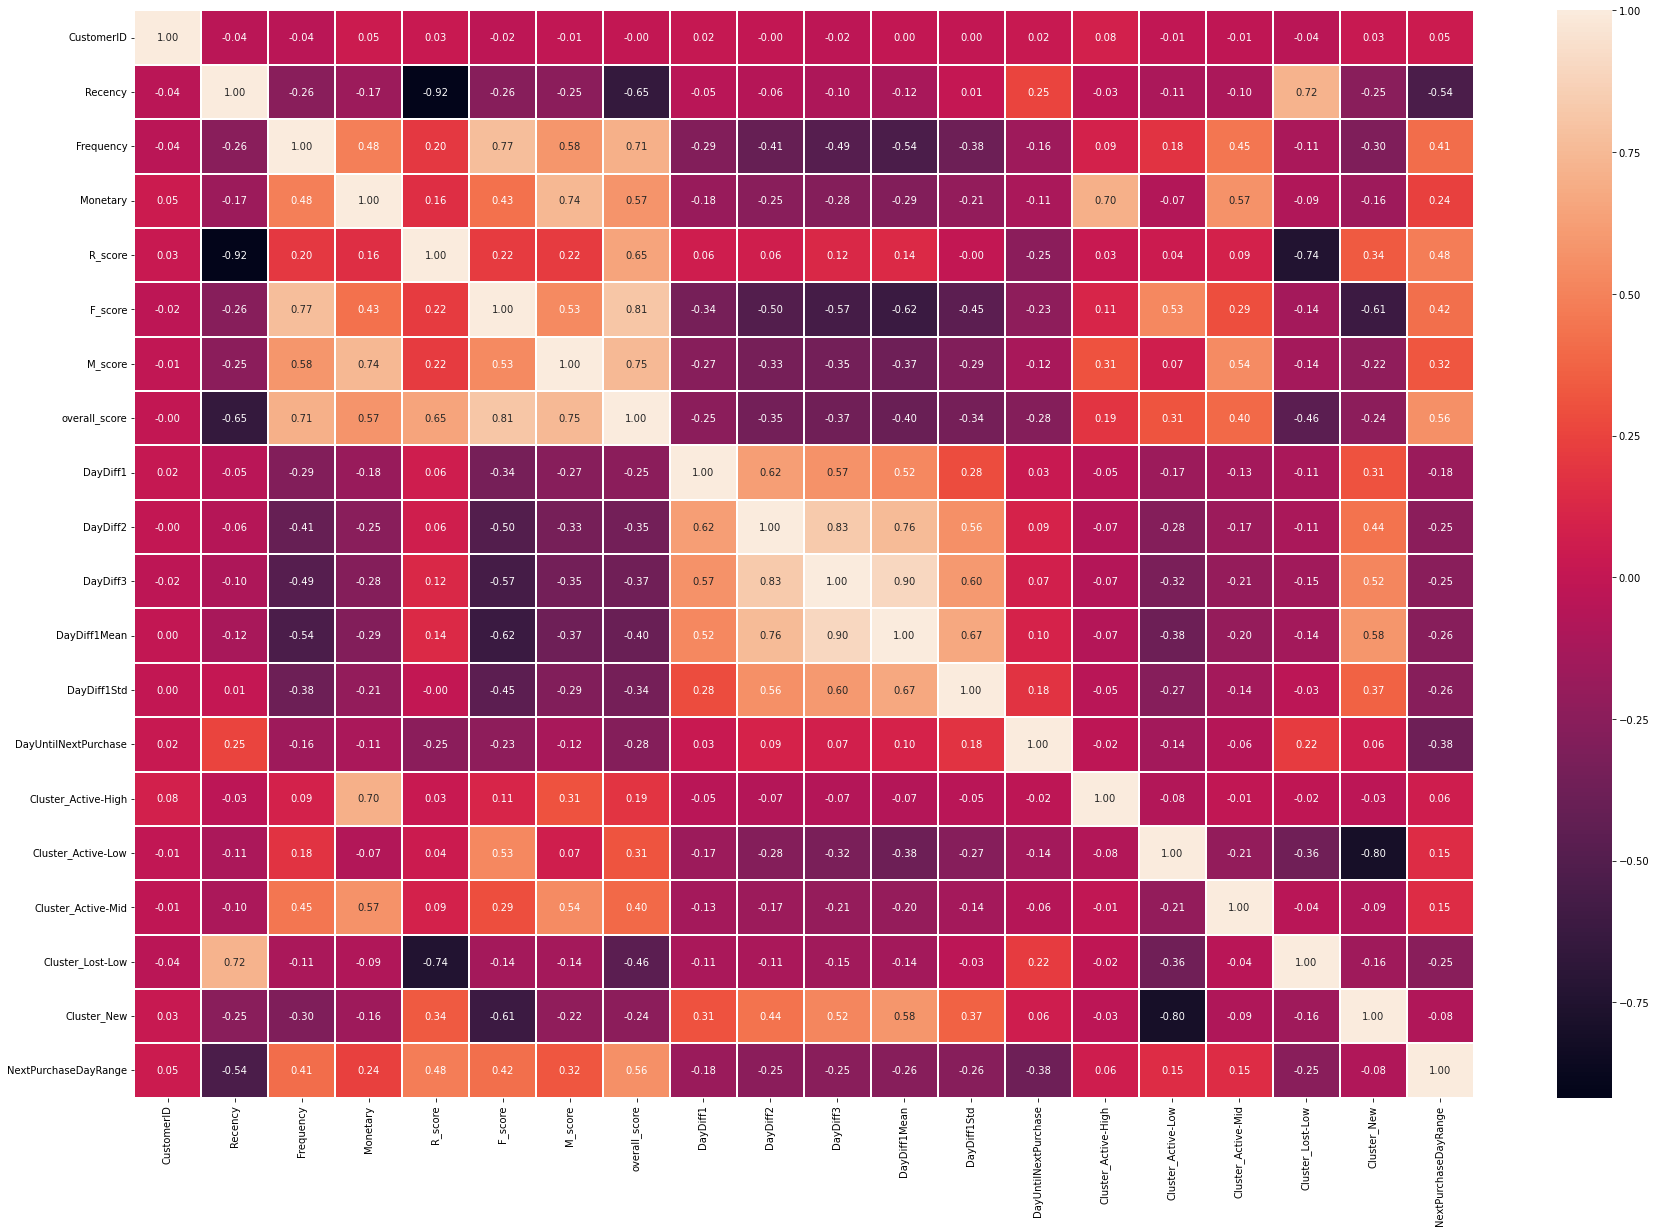

In [359]:
corr = model[model.columns].corr()
plt.figure(figsize = (30,20))
sns.heatmap(corr, annot = True, linewidths=0.2, fmt=".2f")